The below code will create training and test datasets of aviation fuel candidate molecules. 

As input, it uses full GDB-17, unsaturated hydrocarbon GDB-13 and a third precompiled dataset of known fuel molecules. It will filter out molecules containing non-C/H atoms, check for C6-C20, limit rings to 3 and aromatic rings to 1, and perform a duplicate check. 
The remaining molecules are normalised based on C count and ranked by synthetic accessibilty score, and filtered down to 12_500 molecules. This is further split 80/20 to train/test. 

Please note that the download of GDB-17 is around 300MB, and the unpacked file is ca 1.5GB. Also note, that the filtering takes around 45 minutes on my personal computer due to the large size of GDB-17. 

In [ ]:
#TODO: add parameter file to this script, helps to make things clearer
#TODO: switch out GDB17 for Coconut, making sure to remove stereochemistry from it, and filter it down in a similar way to GDB13
#TODO: look more into non-aromatic double and triple bonds, and how they are represented in the dataset. Should I just remove or clean them up?
#TODO: look into the aromaticity of the dataset, and how it is represented in the dataset. Should I just remove or clean them up?
#TODO: look into spearheading, cages, cycloalkanes. 
#TODO: make sure to keep both semi-filtered dataset (ca 200k molecules) and fully filtered dataset (ca  12_500 molecules). 
#TODO: add another synthesis difficulty score for sanity check (SA is based on drugs, different molecule set)

### Imports and config

In [ ]:
import csv
import gzip
import io
import math
import pathlib
import random
import shutil
import subprocess
import tarfile
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Contrib.SA_Score import sascorer
from tqdm.auto import tqdm

# URLs
URL_GDB17 = ("https://zenodo.org/record/5172018/files/GDB17.50000000.smi.gz?download=1&ref=gdb.unibe.ch")
URL_GDB13 = ("https://zenodo.org/record/5172018/files/gdb13.g.tgz?download=1&ref=gdb.unibe.ch")

# File-system layout
DATA_DIR   = pathlib.Path("data/")
DATA_DIR.mkdir(parents=True, exist_ok=True)

GDB17_GZ   = DATA_DIR / "GDB17.50000000.smi.gz"
GDB17_RAW  = DATA_DIR / "GDB17_raw.smi"

GDB13_TGZ  = DATA_DIR / "gdb13.g.tgz"
GDB13_DIR  = DATA_DIR / "gdb13_smi"      # where the 1.g.smi … 13.g.smi land

# EXTRA_PATH = DATA_DIR / "1-s2.0-S0016236123025267-mmc1.csv"  
# Cleaned real-fuel set. I found it to have a high number of aromatic rings, which biased the final dataset. Remove it for now.
# Likely not enough reason to keep it for now, using only filtered large general datasets is also more justifyable in the paper.  

VALID_PATH = DATA_DIR / "filtered_saf_candidates.csv"         # with SA + C
ALL_PATH   = DATA_DIR / "combinedSet_all.csv"                 # header-less SMILES
TRAIN_PATH = DATA_DIR / "combinedSet_train.csv"
TEST_PATH  = DATA_DIR / "combinedSet_test.csv"

# Constants
TOTAL_LINES   = 50_500_000          # tqdm reference for progress bar
CARBON_LO     = 8                 
CARBON_HI     = 20
MAX_RINGS     = 3
MAX_ARO_RINGS = 1
TARGET_N      = 12_500
TRAIN_FRAC    = 0.80
SEED          = 27

random.seed(SEED)

print("Configuration loaded.")

Configuration loaded.


/home/karl/ZH5_Karl/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset downoad and extraction

In [ ]:
def _download(url, dst):
    if dst.exists():
        return
    print(f"Downloading {dst.name} …")
    subprocess.run(["wget", "-q", "-O", str(dst), url], check=True)

def _extract_gdb17():
    if GDB17_RAW.exists():
        return
    _download(URL_GDB17, GDB17_GZ)
    print("Decompressing GDB-17 slice …")
    with gzip.open(GDB17_GZ, "rb") as gz_in, GDB17_RAW.open("wb") as f_out:
        shutil.copyfileobj(gz_in, f_out)
    print("GDB-17 ready.")

def _extract_gdb13():
    if GDB13_DIR.exists():
        return
    _download(URL_GDB13, GDB13_TGZ)
    print("Extracting GDB-13 tgz …")
    with tarfile.open(GDB13_TGZ, "r:gz") as tar:
        tar.extractall(path=GDB13_DIR)
    print("GDB-13 ready ({} files).".format(len(list(GDB13_DIR.glob("*.smi")))))

_extract_gdb17()
_extract_gdb13()

print("All input datasets present.")


All input datasets present.


### Utility helpers

In [ ]:
def _iter_smi_file(path):
    """
    Yield raw SMILES strings from a .smi (no header) or .csv (first column) file.
    """
    with path.open() as f:
        if path.suffix == ".csv":
            reader = csv.reader(f)
            _ = next(reader, None)    # skip header
            for row in reader:
                if row:
                    yield row[0].strip()
        else:                         # .smi   "SMILES [tab] id"
            for line in f:
                if line.strip():
                    yield line.split()[0]

def _passes_filters(mol):
    """
    Quick rough filters - C/H only, specified rings <= 3, aromatic rings <= 1, no triple bonds.
    """
    Chem.FastFindRings(mol)
    
    atoms = mol.GetAtoms()
    
    if any(a.GetAtomicNum() != 6 and a.GetAtomicNum() != 1 for a in atoms):
        return False
    if rdMolDescriptors.CalcNumRings(mol) > MAX_RINGS:
        return False
    if rdMolDescriptors.CalcNumAromaticRings(mol) > MAX_ARO_RINGS:
        return False
    if any(b.GetBondType() == Chem.rdchem.BondType.TRIPLE for b in mol.GetBonds()):
        return False
    return True

def _count_carbons(smi: str) -> int:
    """Return the number of carbon atoms in a SMILES string.
       Assumes the string is valid; returns -1 if RDKit parsing fails."""
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return -1
    return sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() == 6)

smi_to_c = {smi: _count_carbons(smi) for smi, _ in selected}

### Initial dataset filtering

In [ ]:
t0 = time.perf_counter()

canonical_seen  = set()
valid_records   = []          # (canonical, SA, C)

# GDB-17  (single huge file)
print("\nFiltering GDB-17 …")
with tqdm(total=TOTAL_LINES, unit="lines") as bar:
    for raw in _iter_smi_file(GDB17_RAW):
        bar.update(1)
        mol = Chem.MolFromSmiles(raw, sanitize=False)
        if mol is None or not _passes_filters(mol):
            continue
        try:
            Chem.SanitizeMol(mol)
        except Exception:
            continue
        c_count = mol.GetNumAtoms()
        if not (CARBON_LO <= c_count <= CARBON_HI):
            continue
        can = Chem.MolToSmiles(mol, canonical=True)
        if can in canonical_seen:
            continue
        canonical_seen.add(can)
        sa = sascorer.calculateScore(mol)
        valid_records.append((can, sa, c_count))
bar.close()
print(f"GDB-17: kept {len(valid_records):,} molecules.")

# GDB-13  (13 per-C-count files)
print("\nFiltering GDB-13 …")
gdb13_files = sorted(GDB13_DIR.glob("*.smi"))
for p in tqdm(gdb13_files, desc="GDB-13 files"):
    for raw in _iter_smi_file(p):
        mol = Chem.MolFromSmiles(raw, sanitize=False)
        if mol is None or not _passes_filters(mol):
            continue
        try:
            Chem.SanitizeMol(mol)
        except Exception:
            continue
        c_count = mol.GetNumAtoms()
        if not (CARBON_LO <= c_count <= CARBON_HI):
            continue
        can = Chem.MolToSmiles(mol, canonical=True)
        if can in canonical_seen:
            continue
        canonical_seen.add(can)
        sa = sascorer.calculateScore(mol)
        valid_records.append((can, sa, c_count))
print(f"GDB-13: cumulative total now {len(valid_records):,}.")

# Third dataset (already cleaned)
#print("\nLoading curated real-fuel set …")
#for smi in tqdm(_iter_smi_file(EXTRA_PATH), total=0, desc="Real fuels"):  # tqdm without total
#    mol = Chem.MolFromSmiles(smi)
#    if mol is None:
#        continue
#    can = Chem.MolToSmiles(mol, canonical=True)
#    if can in canonical_seen:
#        continue
#    canonical_seen.add(can)
#    sa   = sascorer.calculateScore(mol)
#    c_ct = mol.GetNumAtoms()
#    valid_records.append((can, sa, c_ct))

print(f"After all three sources: {len(valid_records):,} unique molecules.")
print(f"Filtering completed in {time.perf_counter() - t0:,.1f} s.")



Filtering GDB-17 …


 99%|█████████▉| 50000000/50500000 [38:14<00:22, 21789.24lines/s] 


GDB-17: kept 14,823 molecules.

Filtering GDB-13 …


GDB-13 files: 100%|██████████| 13/13 [01:12<00:00,  5.60s/it]

GDB-13: cumulative total now 194,552.
After all three sources: 194,552 unique molecules.
Filtering completed in 2,367.6 s.


Inbetween, here is a small test to explore the JP-10-like strained cycloalkenes. 

In [7]:
print("\nEDA: ring & strain-related descriptors...")
ring_size_counter   = Counter()
bridgehead_counter  = Counter()
spiro_counter       = Counter()
fused_counter       = Counter()

for smi, sa, c in valid_records:
    mol = Chem.MolFromSmiles(smi)
    ri  = mol.GetRingInfo()

    if ri.NumRings():
        smallest = min(len(r) for r in ri.AtomRings())
        ring_size_counter[smallest] += 1
        fused_counter[ri.NumRings()] += 1
    else:
        ring_size_counter[0] += 1
        fused_counter[0]     += 1

    bridgehead_counter[rdMolDescriptors.CalcNumBridgeheadAtoms(mol)] += 1
    spiro_counter[rdMolDescriptors.CalcNumSpiroAtoms(mol)]          += 1

def _pretty(counter, label):
    print(f"\n{label}:")
    for k, v in sorted(counter.items()):
        print(f"  {k}: {v:,}")

_pretty(ring_size_counter,  "Smallest ring size")
_pretty(bridgehead_counter, "Bridgehead atom count")
_pretty(spiro_counter,      "Spiro atom count")
_pretty(fused_counter,      "Fused / bridged ring excess (NumRings - SSSR)")


EDA: ring & strain-related descriptors...

Smallest ring size:
  0: 1,499
  3: 108,806
  4: 54,311
  5: 22,704
  6: 5,080
  7: 1,362
  8: 500
  9: 177
  10: 69
  11: 29
  12: 12
  13: 2
  14: 1

Bridgehead atom count:
  0: 115,282
  2: 56,898
  3: 2,320
  4: 20,052

Spiro atom count:
  0: 161,298
  1: 31,780
  2: 1,474

Fused / bridged ring excess (NumRings - SSSR):
  0: 1,499
  1: 14,662
  2: 49,698
  3: 91,209
  4: 33,901
  5: 2,417
  6: 1,166


### Normalisation and ranking for final filtering

In [ ]:
print("\nNormalising carbon-count distribution ...")
records_by_c = defaultdict(list)
for smi, sa, c in valid_records:
    records_by_c[c].append((smi, sa))

# Quota per carbon bucket
unique_cs = sorted(records_by_c)
quota = math.ceil(TARGET_N / len(unique_cs))
print(f"Quota per C-count = {quota}  (target {TARGET_N})")

selected = []
deficit   = 0
for c in unique_cs:
    bucket = sorted(records_by_c[c], key=lambda t: t[1])      # by SA ascending
    selected.extend(bucket[:quota])
    taken = len(bucket[:quota])
    deficit += max(0, quota - taken)

# Top-up if any buckets were short
if deficit:
    leftovers = []
    for c in unique_cs:
        leftovers.extend(records_by_c[c][quota:])
    leftovers_sorted = sorted(leftovers, key=lambda t: t[1])
    selected.extend(leftovers_sorted[:deficit])

random.shuffle(selected)    # preserves seed 27 via global random
selected = selected[:TARGET_N]   # just in case

print(f"Selected {len(selected):,} molecules after balancing.")



Normalising carbon-count distribution ...
Quota per C-count = 1250  (target 12500)
Selected 12,500 molecules after balancing.


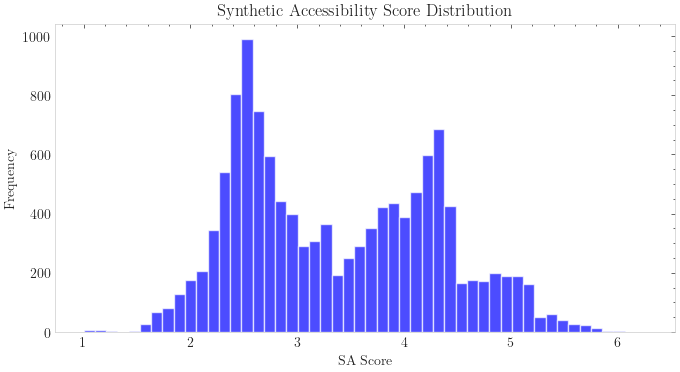

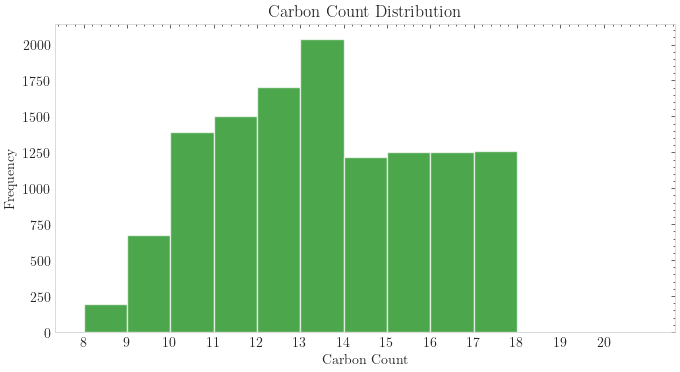

In [ ]:
# Show SA histogram
sa_values = [sa for _, sa in selected]
plt.figure(figsize=(8, 4))
plt.hist(sa_values, bins=50)
plt.title("Synthetic Accessibility Score Distribution")
plt.xlabel("SA Score")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()
# Show C-count histogram
# Use valid_records or another source for carbon counts, or reconstruct from selected if possible
# If you have a mapping from SMILES to C count:
c_counts = [smi_to_c[smi] for smi, _ in selected]
plt.figure(figsize=(8, 4))
plt.hist(c_counts, bins=range(CARBON_LO, CARBON_HI + 2))
plt.title("Carbon Count Distribution")
plt.xlabel("Carbon Count")
plt.ylabel("Frequency")
plt.xticks(range(CARBON_LO, CARBON_HI + 1))
plt.grid(False)
plt.show()

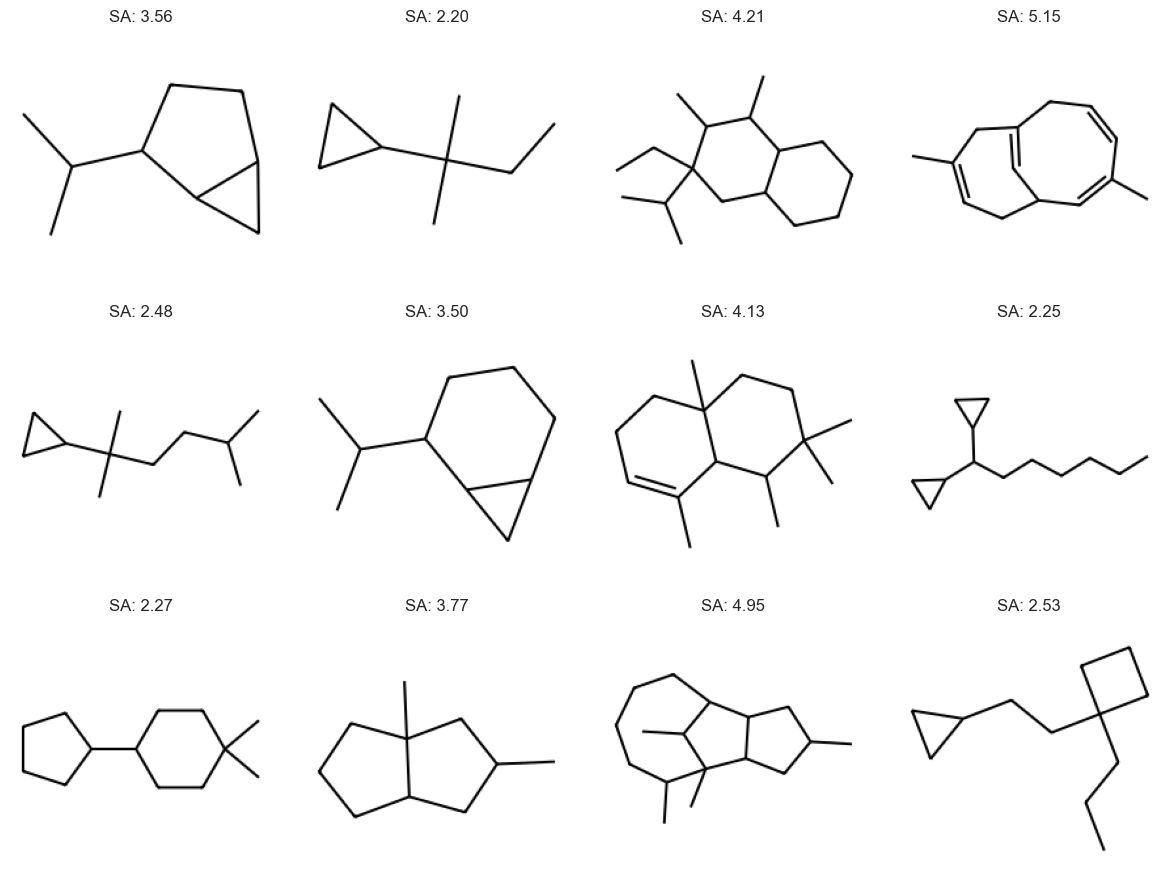

In [ ]:
# Show random sample of 12 molecules as 4x3 grid
sample = random.sample(selected, 12)
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for ax, (smi, sa) in zip(axes.flatten(), sample):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    img = Chem.Draw.MolToImage(mol, size=(200, 200))
    ax.imshow(img)
    ax.set_title(f"SA: {sa:.2f}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### Write to CSVs

In [ ]:
all_smiles = [s for s, _sa in [(rec[0], rec[1]) for rec in selected]]

# Train / test split
split_idx = int(len(all_smiles) * TRAIN_FRAC)
train_smiles = all_smiles[:split_idx]
test_smiles  = all_smiles[split_idx:]

def _dump(path, iterable):
    with path.open("w") as f:
        for smi in iterable:
            f.write(smi + "\n")

_dump(ALL_PATH,   all_smiles)
_dump(TRAIN_PATH, train_smiles)
_dump(TEST_PATH,  test_smiles)

# Also keep a diagnostic file with SA + C (headered)
with VALID_PATH.open("w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["SMILES", "SA", "C"])
    for smi, sa in selected:
        c = smi_to_c[smi]
        w.writerow([smi, f"{sa:.3f}", c])

print(f"Wrote:\n  {ALL_PATH}\n  {TRAIN_PATH}\n  {TEST_PATH}\n  {VALID_PATH}")


Wrote:
  data/combinedSet_all.csv
  data/combinedSet_train.csv
  data/combinedSet_test.csv
  data/filtered_saf_candidates.csv


### Ring stat exploration

In [ ]:
print("\nEDA: ring & strain-related descriptors ...")
ring_size_counter   = Counter()
bridgehead_counter  = Counter()
spiro_counter       = Counter()
fused_counter       = Counter()

for smi in tqdm(all_smiles, desc="Analysing"):
    mol = Chem.MolFromSmiles(smi)
    ri  = mol.GetRingInfo()

    if ri.NumRings():
        smallest = min(len(r) for r in ri.AtomRings())
        ring_size_counter[smallest] += 1
        # Fused/bridged: count as number of rings
        fused_counter[ri.NumRings()] += 1
    else:
        ring_size_counter[0] += 1
        fused_counter[0]     += 1

    bridgehead_counter[rdMolDescriptors.CalcNumBridgeheadAtoms(mol)] += 1
    spiro_counter[rdMolDescriptors.CalcNumSpiroAtoms(mol)]          += 1

def _pretty(counter, label):
    print(f"\n{label}:")
    for k, v in sorted(counter.items()):
        print(f"  {k}: {v:,}")

_pretty(ring_size_counter,  "Smallest ring size")
_pretty(bridgehead_counter, "Bridgehead atom count")
_pretty(spiro_counter,      "Spiro atom count")
_pretty(fused_counter,      "Fused / bridged ring excess (NumRings - SSSR)")


EDA: ring & strain-related descriptors ...


Analysing: 100%|██████████| 12500/12500 [00:02<00:00, 5486.82it/s]


Smallest ring size:
  0: 931
  3: 4,357
  4: 2,936
  5: 2,231
  6: 1,087
  7: 475
  8: 295
  9: 93
  10: 51
  11: 28
  12: 12
  13: 3
  14: 1

Bridgehead atom count:
  0: 11,243
  2: 1,143
  3: 2
  4: 112

Spiro atom count:
  0: 11,826
  1: 650
  2: 24

Fused / bridged ring excess (NumRings - SSSR):
  0: 931
  1: 3,837
  2: 4,833
  3: 2,602
  4: 274
  5: 11
  6: 12


### Recap

In [ ]:
print(f"\nPipeline finished.\n  Total canonical molecules kept: {len(all_smiles):,}")
print(f"  Train : {len(train_smiles):,}")
print(f"  Test  : {len(test_smiles):,}")



Pipeline finished.
  Total canonical molecules kept: 12,500
  Train : 10,000
  Test  : 2,500


### General exploratory data analysis

In [45]:
# Print longest and shortest SMILES in the dataset, their C counts and overall lengths
def _print_smi_info(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    c_count = mol.GetNumAtoms()
    return smi, c_count, len(smi)

longest = max(all_smiles, key=lambda s: len(s))
shortest = min(all_smiles, key=lambda s: len(s))
longest_info = _print_smi_info(longest)
shortest_info = _print_smi_info(shortest)
print(f"\nLongest SMILES: {longest_info[0]} (C: {longest_info[1]}, Length: {longest_info[2]})")
print(f"Shortest SMILES: {shortest_info[0]} (C: {shortest_info[1]}, Length: {shortest_info[2]})") 


Longest SMILES: CC1C(C(C)(C)C)C(C)(C(C)(C)C)CC1(C)C (C: 17, Length: 35)
Shortest SMILES: CCCCCCCC (C: 8, Length: 8)


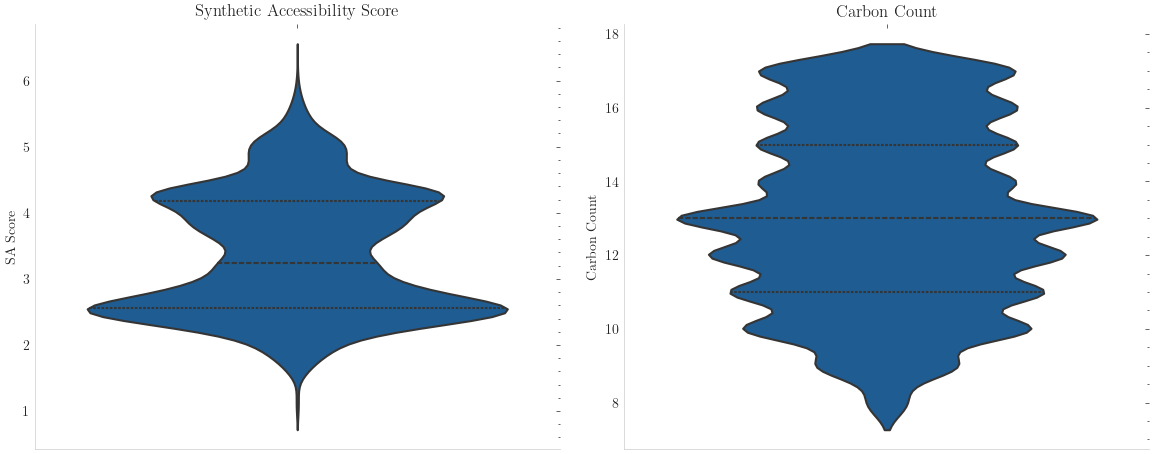

In [46]:
import seaborn as sns
import scienceplots

plt.style.use('science')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# SA violin plot (left)
sns.violinplot(y=[sa for _, sa in selected], ax=axes[0],
               inner='quartile', linewidth=1.5)
axes[0].set_title("Synthetic Accessibility Score")
axes[0].set_ylabel("SA Score")
axes[0].set_xlabel("")
axes[0].grid(False)
sns.despine(ax=axes[0])

# C count violin plot (right)
sns.violinplot(y=[smi_to_c[smi] for smi, _ in selected], ax=axes[1],
               inner='quartile', linewidth=1.5)
axes[1].set_title("Carbon Count")
axes[1].set_ylabel("Carbon Count")
axes[1].set_xlabel("")
axes[1].grid(False)
sns.despine(ax=axes[1])

plt.tight_layout(pad=2)
plt.savefig("violin_plots.svg")
plt.savefig("violin_plots.pdf")
plt.savefig("violin_plots.png", dpi=300)
plt.show()

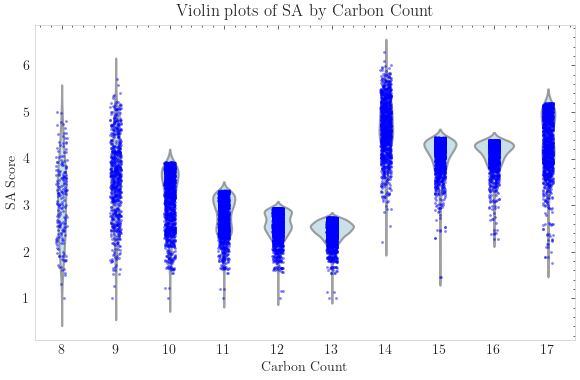

In [ ]:
plt.figure(figsize=(6, 4))
sns.violinplot(x=[smi_to_c[smi] for smi, _ in selected], y=[sa for _, sa in selected],
               inner=None)
sns.stripplot(x=[smi_to_c[smi] for smi, _ in selected], y=[sa for _, sa in selected],
              size=2, jitter=True, ax=plt.gca())
plt.title("Violin plots of SA by Carbon Count")
plt.xlabel("Carbon Count")
plt.ylabel("SA Score")
plt.tight_layout()
plt.grid(False)
plt.savefig("strip_over_violin_hybrid.png", dpi=300)
plt.savefig("strip_over_violin_hybrid.svg")
plt.savefig("strip_over_violin_hybrid.pdf")
plt.show()


In [48]:
# Check for number of SMILES with aromatic rings from data/filtered_saf_candidates.csv
aromatic_count = 0
with VALID_PATH.open() as f:
    reader = csv.reader(f)
    next(reader, None)  # skip header
    for row in reader:
        smi = row[0]
        mol = Chem.MolFromSmiles(smi)
        if mol and any(atom.GetIsAromatic() for atom in mol.GetAtoms()):
            aromatic_count += 1
print(f"Number of SMILES with aromatic rings: {aromatic_count}")
# Check for number of SMILES with spiro atoms from data/filtered_saf_candidates.csv
spiro_count = 0
with VALID_PATH.open() as f:
    reader = csv.reader(f)
    next(reader, None)  # skip header
    for row in reader:
        smi = row[0]
        mol = Chem.MolFromSmiles(smi)
        if mol and rdMolDescriptors.CalcNumSpiroAtoms(mol) > 0:
            spiro_count += 1
print(f"Number of SMILES with spiro atoms: {spiro_count}")

Number of SMILES with aromatic rings: 169
Number of SMILES with spiro atoms: 674


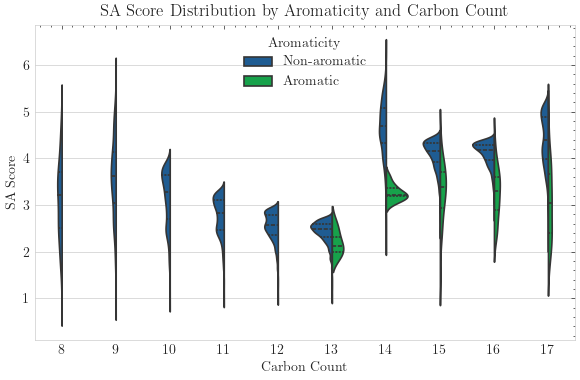

In [ ]:
import pandas as pd

# Load data and annotate aromaticity and carbon count
records = []
with VALID_PATH.open() as f:
    reader = csv.reader(f)
    next(reader, None)  # skip header
    for row in reader:
        smi = row[0]
        sa = float(row[1])
        c = int(row[2])
        mol = Chem.MolFromSmiles(smi)
        if mol:
            aromatic = any(atom.GetIsAromatic() for atom in mol.GetAtoms())
            records.append({'SA': sa, 'Aromatic': 'Aromatic' if aromatic else 'Non-aromatic', 'C': c})

df = pd.DataFrame(records)

import seaborn as sns
import scienceplots
plt.style.use('science')
plt.figure(figsize=(6,4))
sns.violinplot(x='C', y='SA', hue='Aromatic', data=df, split=True, inner='quartile')
plt.title("SA Score Distribution by Aromaticity and Carbon Count")
plt.xlabel("Carbon Count")
plt.ylabel("SA Score")
plt.legend(title="Aromaticity")
plt.tight_layout()
plt.savefig("aromaticity_vs_sa.png", dpi=300)
plt.savefig("aromaticity_vs_sa.svg")
plt.savefig("aromaticity_vs_sa.pdf")
plt.show()